## Análisis de datos - Clase 5

### Técnicas avanzadas para el tratamiento de datos faltantes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

### Identificamos datos faltantes

In [2]:
# Cargamos el dataset de Titanic de Seaborn
titanic = sns.load_dataset("titanic")

# split 80%/20% (sin target definido)
df, test_df = train_test_split(titanic, test_size=0.2, random_state=42)

print(df.shape, test_df.shape)

(712, 15) (179, 15)


In [3]:
df.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
331,0,1,male,45.5,0,0,28.5000,S,First,man,True,C,Southampton,no,True
733,0,2,male,23.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
382,0,3,male,32.0,0,0,7.9250,S,Third,man,True,NaN,Southampton,no,True
704,0,3,male,26.0,1,0,7.8542,S,Third,man,True,NaN,Southampton,no,False
813,0,3,female,6.0,4,2,31.2750,S,Third,child,False,NaN,Southampton,no,False
118,0,1,male,24.0,0,1,247.5208,C,First,man,True,B,Cherbourg,no,False
536,0,1,male,45.0,0,0,26.5500,S,First,man,True,B,Southampton,no,True
361,0,2,male,29.0,1,0,27.7208,C,Second,man,True,NaN,Cherbourg,no,False
29,0,3,male,NaN,0,0,7.8958,S,Third,man,True,NaN,Southampton,no,True
55,1,1,male,NaN,0,0,35.5000,S,First,man,True,C,Southampton,yes,True


In [4]:
df.isna().sum()[df.isna().sum() > 0] # columnas con datos faltantes

age            140
embarked         2
deck           554
embark_town      2
dtype: int64

### Tratamiento de datos faltantes

#### Imputación - Métodos multivariados

Cuando tengo datos MAR con patrones claros

* KNN (*K-Nearest Neighbors*)

Cuando tengo datos MAR con patrones complejos
* MICE (*Multiple Imputation by Chained Equations*)

In [5]:
# Creo una copia reducida del dataset original
titanic_2 = df[['age', 'pclass', 'sex', 'embarked']].copy() #hacemos una copia reducida del dataset original
titanic_2.head()

,age,pclass,sex,embarked
331,45.5,1,male,S
733,23.0,2,male,S
382,32.0,3,male,S
704,26.0,3,male,S
813,6.0,3,female,S


In [6]:
titanic_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 331 to 102
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       572 non-null    float64
 1   pclass    712 non-null    int64  
 2   sex       712 non-null    object 
 3   embarked  710 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 27.8+ KB


#### a) Imputación con KNN

In [7]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [8]:
# Prerrequisitos para cualquier modelo - Necesitamos hacer encoding de las variables categóricas

le_sex = LabelEncoder() 
le_embarked = LabelEncoder()

# Codificamos las categóricas 
titanic_2['sex'] = le_sex.fit_transform(titanic_2['sex'])
titanic_2['embarked'] = le_embarked.fit_transform(titanic_2['embarked'].fillna(titanic_2['embarked'].mode()[0]))  # Antes de codificar, imputo con la moda, porque esta variable también tiene nulos (solo 2)

titanic_2.head()

,age,pclass,sex,embarked
331,45.5,1,1,2
733,23.0,2,1,2
382,32.0,3,1,2
704,26.0,3,1,2
813,6.0,3,0,2


In [9]:
# Prerequisito para KNNImputer: escalamiento

scaler = MinMaxScaler()
titanic_2_escalado = scaler.fit_transform(titanic_2)

In [10]:
# Definimos el modelo
knn_imputer = KNNImputer(n_neighbors=5)

# Aplicamos la imputación
titanic_escalado_imputado_knn = pd.DataFrame(
    knn_imputer.fit_transform(titanic_2_escalado),
    columns=titanic_2.columns,
    index=titanic_2.index
)

# "Desescalamos" los datos imputados
titanic_imputado_knn = pd.DataFrame(
    scaler.inverse_transform(titanic_escalado_imputado_knn),
    columns=titanic_2.columns,
    index=titanic_2.index
)

# Postprocesamiento del dataset imputado (decodificación)
titanic_imputado_knn['pclass'] = titanic_imputado_knn['pclass'].astype(int)
titanic_imputado_knn['sex'] = le_sex.inverse_transform(titanic_imputado_knn['sex'].astype(int))
titanic_imputado_knn['embarked'] = le_embarked.inverse_transform(titanic_imputado_knn['embarked'].astype(int))
titanic_imputado_knn['age'] = titanic_imputado_knn['age'].clip(lower=0)

print(f"Dataset imputado con KNN (postprocesado):\n {titanic_imputado_knn.head()}")

Dataset imputado con KNN (postprocesado):
       age  pclass     sex embarked
331  45.5       1    male        S
733  23.0       2    male        S
382  32.0       3    male        S
704  26.0       3    male        S
813   6.0       3  female        S


In [11]:
# miro las observaciones que fueron imputadas
df_compara = pd.concat([titanic_2['age'], titanic_imputado_knn], axis=1)
df_compara.columns = ['age_original', 'age_imputada', 'pclass', 'sex', 'embarked']
df_compara.head(20)

,age_original,age_imputada,pclass,sex,embarked
331,45.5,45.5,1,male,S
733,23.0,23.0,2,male,S
382,32.0,32.0,3,male,S
704,26.0,26.0,3,male,S
813,6.0,6.0,3,female,S
118,24.0,24.0,1,male,C
536,45.0,45.0,1,male,S
361,29.0,29.0,2,male,C
29,NaN,29.7,3,male,S
55,NaN,47.0,1,male,S


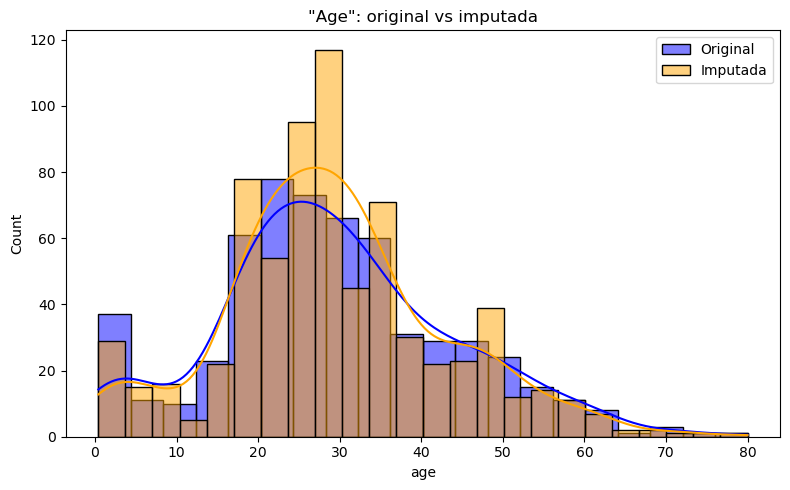

In [12]:
# Visualizar datos originales vs imputados (por ejemplo con el primer dataset imputado)
plt.figure(figsize=(8, 5))

# Age distribution
sns.histplot(titanic_2['age'], label='Original', kde=True, color='blue', alpha=0.5)
sns.histplot(titanic_imputado_knn['age'], label='Imputada', kde=True, color='orange', alpha=0.5)
plt.title('"Age": original vs imputada')
plt.legend()

plt.tight_layout()
plt.show()


#### b) Imputación con MICE

In [13]:
from statsmodels.imputation import mice

In [14]:
# Prerequisito para MICE con OLS: escalamiento

scaler = StandardScaler()
titanic_3_escalado = scaler.fit_transform(titanic_2)

In [15]:
# Definimos el modelo
imp = mice.MICEData(pd.DataFrame(titanic_3_escalado, columns=titanic_2.columns))

# Armamos los modelos para imputar
imp.set_imputer('age', formula='C(pclass) + sex + embarked', model_class=sm.OLS) # OLS es el modelo por defecto, hay muchos más

In [16]:
# Aplicar la imputación - generar 10 datasets imputados
imp.update_all(n_iter=10)

# Extraer el dataset imputado resultante (de la última iteración de MICE)
titanic_imp_mice_raw = imp.data.copy()
print(f"Dataset resultante (codificado):\n {titanic_imp_mice_raw.head()}\n\n")

# Este dataset es el que voy a "decodificar" (volver a las variables originales)
titanic_imputado_mice = imp.data.copy()

Dataset resultante (codificado):
         age    pclass       sex  embarked
0  1.104489 -1.614136  0.724310  0.563525
1 -0.448587 -0.400551  0.724310  0.563525
2  0.172644  0.813034  0.724310  0.563525
3 -0.241510  0.813034  0.724310  0.563525
4 -1.622022  0.813034 -1.380624  0.563525




In [17]:
# Desescalar el dataset imputado para visualizarlo
titanic_imputado_mice= scaler.inverse_transform(titanic_imputado_mice)
titanic_imputado_mice = pd.DataFrame(titanic_imputado_mice, columns=titanic_imp_mice_raw.columns)

titanic_imputado_mice.head()

,age,pclass,sex,embarked
0,45.5,1.0,1.0,2.0
1,23.0,2.0,1.0,2.0
2,32.0,3.0,1.0,2.0
3,26.0,3.0,1.0,2.0
4,6.0,3.0,0.0,2.0


In [18]:
titanic_imputado_mice.isna().sum()

age         0
pclass      0
sex         0
embarked    0
dtype: int64

In [19]:
# Postprocesar el dataset imputado para visualizarlo
titanic_imputado_mice['pclass'] = titanic_imputado_mice['pclass'].astype(int)
titanic_imputado_mice['sex'] = le_sex.inverse_transform(titanic_imputado_mice['sex'].astype(int))
titanic_imputado_mice['embarked'] = le_embarked.inverse_transform(titanic_imputado_mice['embarked'].astype(int))
titanic_imputado_mice['age'] = titanic_imputado_mice['age'].clip(lower=0)

print(f"Dataset imputado y postprocesado:\n {titanic_imputado_mice.head(10)}")


Dataset imputado y postprocesado:
     age  pclass     sex embarked
0  45.5       1    male        S
1  23.0       2    male        S
2  32.0       3    male        S
3  26.0       3    male        S
4   6.0       3  female        S
5  24.0       1    male        C
6  45.0       1    male        S
7  29.0       2    male        C
8  18.0       3    male        S
9  65.0       1    male        S


Nota: el valor típico de n_iter que se suele utilizar es entre 5 y 20 iteraciones. Se pueden aumentar si el dataset tiene dependencias muy complejas y el porcentaje de faltantes es alto (por ej >30%).

Visualizamos el dataset original y el imputado:

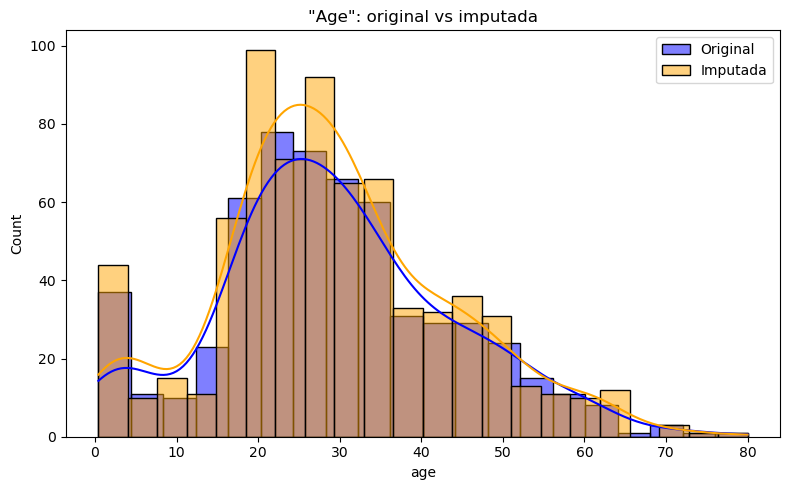

In [20]:
# Visualizar datos originales vs imputados (por ejemplo con el primer dataset imputado)
plt.figure(figsize=(8, 5))

# Age distribution
sns.histplot(titanic_2['age'], label='Original', kde=True, color='blue', alpha=0.5)
sns.histplot(titanic_imputado_mice['age'], label='Imputada', kde=True, color='orange', alpha=0.5)
plt.title('"Age": original vs imputada')
plt.legend()


plt.tight_layout()
plt.show()



Observación: como Statsmodels permite crear múltiples versiones del dataset imputado, por ejemplo:

```python
# Podemos generar distintas versiones del dataset imputado, para hacer un análisis de sensibilidad
titanic_imputados = [titanic_mar_imputado] + [imp.next_sample() for _ in range(4)]
```
Esos datasets se pueden usar luego para hacer un análisis de sensibilidad.